In [2]:
import os
from sodapy import Socrata
import pandas as pd
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib

%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 5]

In [3]:
if os.path.exists("data.csv"):
    df = pd.read_csv("data.csv", low_memory=False)
else:
    #Descarga de la información
    socrata_domain = "www.datos.gov.co"
    client = Socrata(socrata_domain, None)
    
    socrata_dataset_identifier = "gt2j-8ykr"
    results = client.get(socrata_dataset_identifier,limit=1000000000)

    df = pd.DataFrame.from_dict(results)
    
df_poblacion = pd.read_csv("spreadsheets/top20ciudades.csv")
df.head()

,Unnamed: 0,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,...,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
0,0,1,2020-03-02T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,...,2020-02-27T00:00:00.000,2020-03-06T00:00:00.000,2020-03-13T00:00:00.000,2020-03-06T00:00:00.000,PCR,11,380.0,Otro,NaN,NaN
1,1,2,2020-03-06T00:00:00.000,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,...,2020-03-04T00:00:00.000,2020-03-09T00:00:00.000,2020-03-19T00:00:00.000,2020-03-09T00:00:00.000,PCR,76,724.0,Otro,NaN,NaN
2,2,3,2020-03-07T00:00:00.000,5001,Medellín,Antioquia,Recuperado,50,F,Importado,...,2020-02-29T00:00:00.000,2020-03-09T00:00:00.000,2020-03-15T00:00:00.000,2020-03-09T00:00:00.000,PCR,5,724.0,Otro,NaN,NaN
3,3,4,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,...,2020-03-06T00:00:00.000,2020-03-11T00:00:00.000,2020-03-26T00:00:00.000,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN,NaN
4,4,5,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,...,2020-03-08T00:00:00.000,2020-03-11T00:00:00.000,2020-03-23T00:00:00.000,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN,NaN


In [165]:
df_poblacion.head()

,Ciudad,Departamento,Población
0,Bogotá D.C.,Cundinamarca,8380801
1,Medellín,Antioquia,2569007
2,Cali,Valle del Cauca,2496346
3,Barranquilla,Atlántico,1239804
4,Cartagena de Indias,Bolívar,1057767


## 5 ciudades con mas infectados

In [166]:
cities_cases = df.groupby(by=['ciudad_de_ubicaci_n'], as_index=False).count()[['ciudad_de_ubicaci_n', 'edad']]
cities_cases.rename(columns={"edad": "casos"}, inplace=True)
cities_cases.sort_values("casos", ascending=False, inplace=True)
cities = cities_cases[:5]["ciudad_de_ubicaci_n"].tolist()
cities

['Bogotá D.C.', 'Medellín', 'Cali', 'Barranquilla', 'Cartagena de Indias']

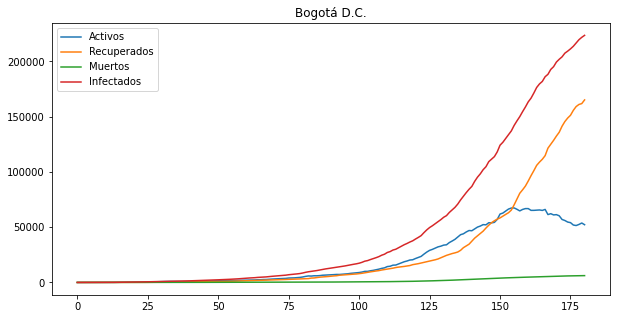

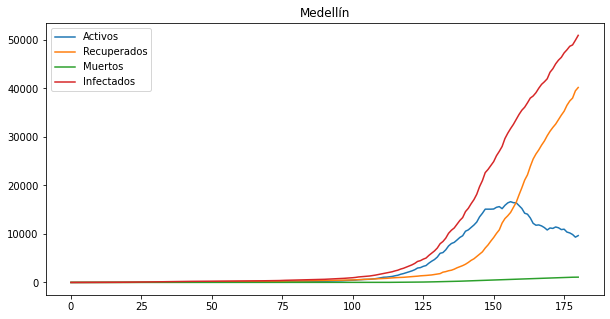

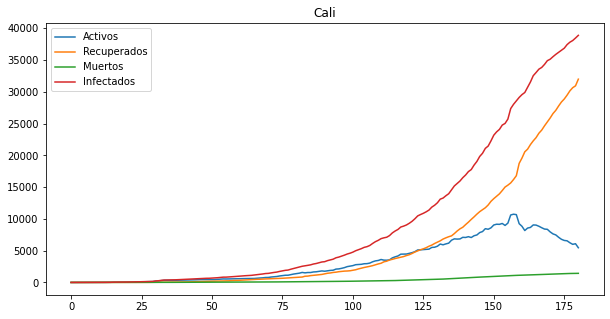

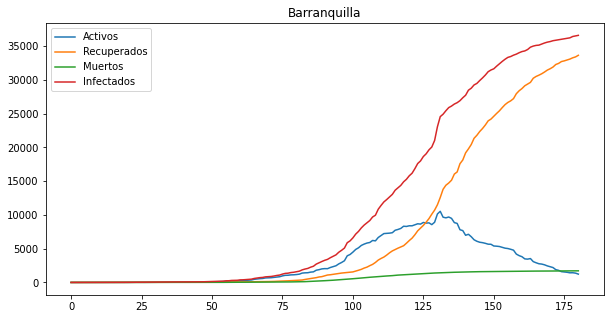

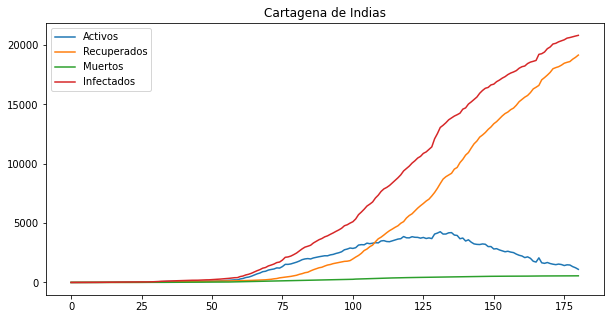

In [229]:
cities_data = dict()
dates_df = pd.DataFrame(df["fecha_reporte_web"].unique(), columns=["fecha_reporte_web"])
dates = dates_df["fecha_reporte_web"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT00:00:00.000")).values
dates = matplotlib.dates.date2num(dates)
campos = ["fecha_reporte_web", "edad", "fecha_recuperado", "fecha_de_muerte"]

for city in cities:
    cities_data[city] = dict()
    city_pop = df_poblacion[df_poblacion["Ciudad"] == city]["Población"].values[0]
    df_city = df[df["ciudad_de_ubicaci_n"] == city]
    
    history_cases = df_city.groupby("fecha_reporte_web", as_index=False).count()
    history_recovery = df_city.groupby("fecha_recuperado", as_index=False).count()
    history_death = df_city.groupby("fecha_de_muerte", as_index=False).count()
    history_cases = pd.merge(dates_df, history_cases, on="fecha_reporte_web", how="left", sort=True).fillna(0)["sexo"].values
    history_recovery = pd.merge(dates_df.rename(columns={"fecha_reporte_web": "fecha_recuperado"}), history_recovery, on="fecha_recuperado", how="left", sort=True).fillna(0)["sexo"].values
    history_death = pd.merge(dates_df.rename(columns={"fecha_reporte_web": "fecha_de_muerte"}), history_death, on="fecha_de_muerte", how="left", sort=True).fillna(0)["sexo"].values
    
    # Derivadas
    cities_data[city]["dSdt"] = - history_cases
    cities_data[city]["dRdt"] = history_recovery
    cities_data[city]["dMdt"] = history_death
    cities_data[city]["dIdt"] = - cities_data[city]["dSdt"] - cities_data[city]["dRdt"] - cities_data[city]["dMdt"]
    
    # Acumulados
    cities_data[city]["S"] = city_pop + cities_data[city]["dSdt"].cumsum()
    cities_data[city]["R"] = cities_data[city]["dRdt"].cumsum()
    cities_data[city]["M"] = cities_data[city]["dMdt"].cumsum()
    cities_data[city]["I"] = cities_data[city]["dIdt"].cumsum()
    
    #print(cities_data[city]["S"] + cities_data[city]["I"] + cities_data[city]["M"] + cities_data[city]["R"])
    
    # Parametros SIR
    plt.figure()
    plt.title(city)
    plt.plot(cities_data[city]["I"])
    plt.plot(cities_data[city]["R"])
    plt.plot(cities_data[city]["M"])
    plt.plot(-cities_data[city]["dSdt"].cumsum())
    plt.legend(["Activos", "Recuperados", "Muertos", "Infectados"])

## Definición modelo SIR

In [475]:
class SIR:
    def __init__(self, population, n):
        self.beta = []
        self.gamma = []
        self.mu = []
        self.population = population
        self.n = n
        
    def obj_func(self, params, data, t, y0):
        beta, gamma, mu = params
        preds = odeint(self.model, y0, t, args=(beta, gamma, mu))
        err = np.sum(np.square(preds.T - data))
        
        return err
        
    def fit(self, y0, t, data):
        results = np.array([[x] for x in y0])
        for i in range(0, len(t), self.n):
            ti = list(range(len(t[i:i + self.n])))
            
            # Find parameter values that minimizes the error between the model and the real data
            params = minimize(self.obj_func, (1, 0, 0), args=(data[:, i:i + self.n], ti, results[:, -1]), bounds=((0, None), (0, None), (0, None)))
            beta, gamma, mu = params.x
            
            self.beta.append(beta)
            self.gamma.append(gamma)
            self.mu.append(mu)
            
            result_i = odeint(self.model, results[:, -1], ti, args=(beta, gamma, mu))
            results = np.concatenate((results, result_i.T), axis=1)
            
            self.last_value = results[:, -1]
            
        self.beta = pd.Series(self.beta).ewm(alpha=0.2).mean().values
        self.gamma = pd.Series(self.gamma).ewm(alpha=0.2).mean().values
        self.mu = pd.Series(self.mu).ewm(alpha=0.2).mean().values
        self.results = results
    
    def predict(self, days):
        beta = self.beta[-1]
        gamma = self.gamma[-1]
        mu = self.mu[-1]
        
        t = list(range(days))
        
        return odeint(self.model, self.last_value, t, args=(beta, gamma, mu)).T
    
    def model(self, y, t, beta, gamma, mu):
        Y = np.zeros((4))
        V = y
        #dS/dt SUCEPTIBLES
        Y[0] = - beta * V[0] * V[1] / self.population
        #dI/dt INFECTADOS
        Y[1] = beta * V[0] * V[1] / self.population - gamma * V[1] - mu * V[1]
        #dR/dt RECUPERADOS
        Y[2] = gamma * V[1] #gama1-20*infectados1-20+gama20-40*infectados20-40
        #dM/dt MUERTES
        Y[3] = mu * V[1]

        return Y
        

## Calculo de parametros del modelo SIR

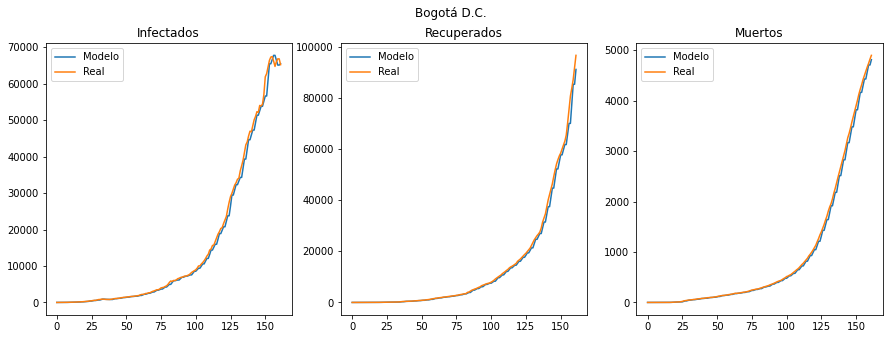

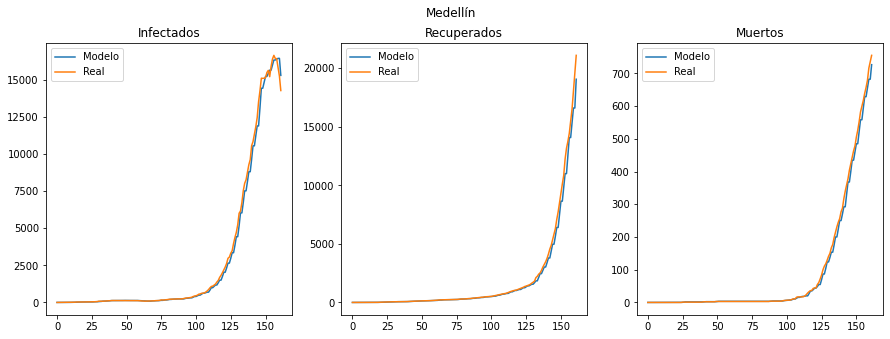

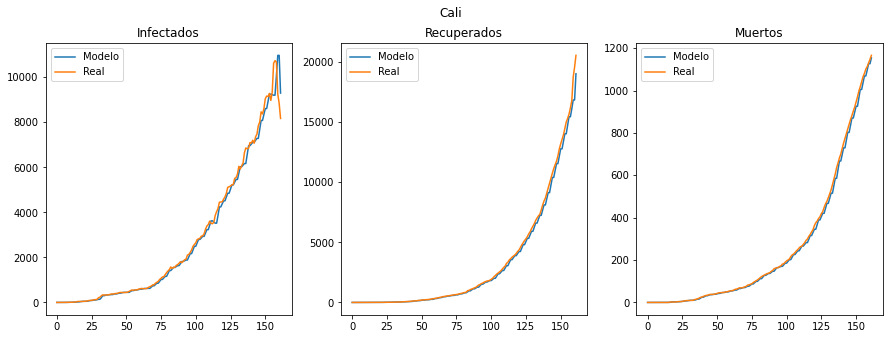

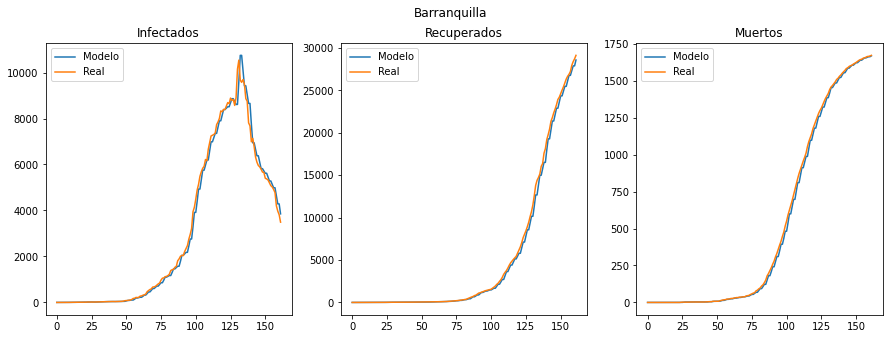

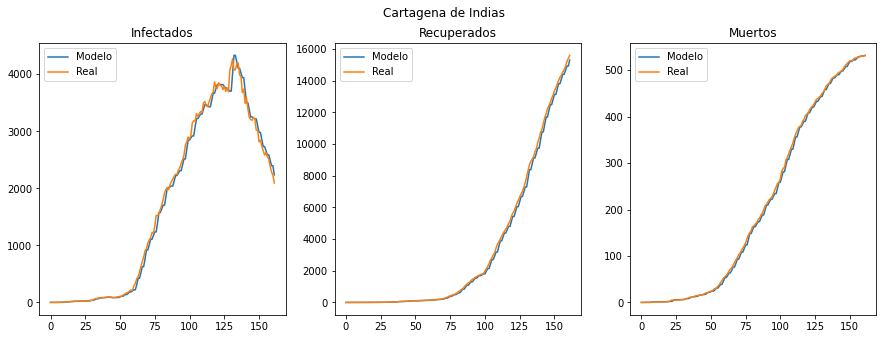

In [476]:
cutpoint = int(len(dates_df) * 0.9)
models = dict()

for city in cities:
    city_pop = df_poblacion[df_poblacion["Ciudad"] == city]["Población"].values[0]
    data = np.array([
        cities_data[city]["S"],
        cities_data[city]["I"],
        cities_data[city]["R"],
        cities_data[city]["M"],
    ])
    
    train_data = data[:, :cutpoint]
    t = np.arange(train_data.shape[1])
    
    
    model = SIR(city_pop, 3)
    
    y0 = [city_pop, 1, 0, 0]
    model.fit(y0, t, train_data)
    models[city] = model
    
    ## FIGURAS
    fig, axes = plt.subplots(nrows=1, ncols=3, squeeze=False)
    fig.suptitle(city)
    axes = axes.flatten()
    # Infectados
    axes[0].plot(t , models[city].results[1][:cutpoint])
    axes[0].plot(t, train_data[1])
    axes[0].legend(["Modelo", "Real"])
    axes[0].set_title("Infectados")
    
    # Recuperados
    axes[1].plot(t, models[city].results[2][:cutpoint])
    axes[1].plot(t, train_data[2])
    axes[1].legend(["Modelo", "Real"])
    axes[1].set_title("Recuperados")
    
    # Muertos
    axes[2].plot(t, models[city].results[3][:cutpoint])
    axes[2].plot(t, train_data[3])
    axes[2].legend(["Modelo", "Real"])
    axes[2].set_title("Muertos")

## Predicciones sobre el conjunto de test

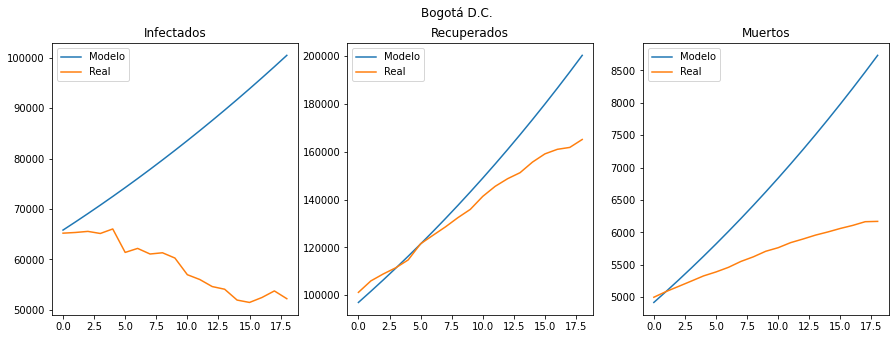

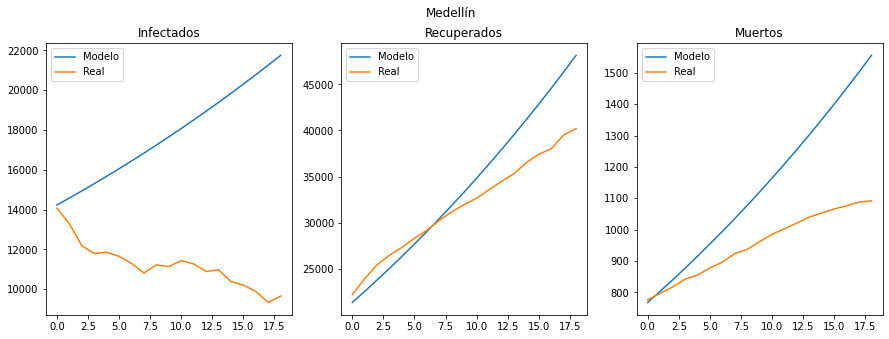

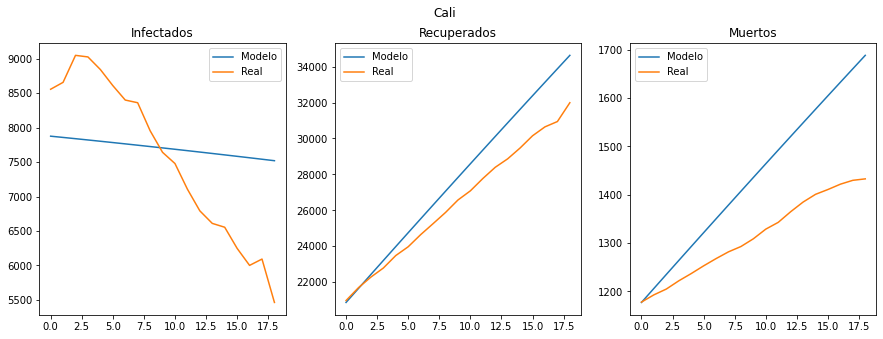

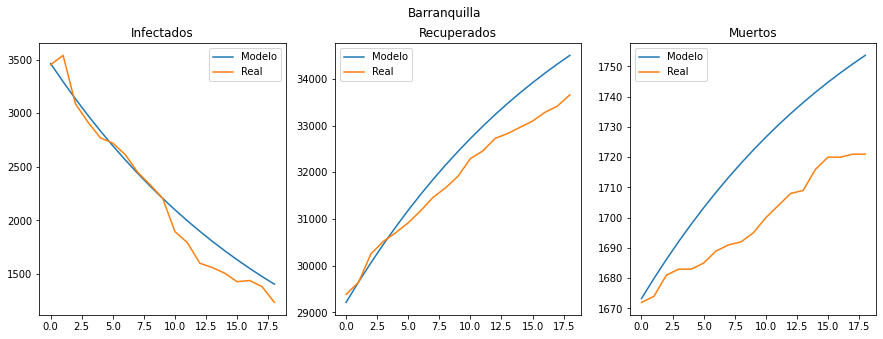

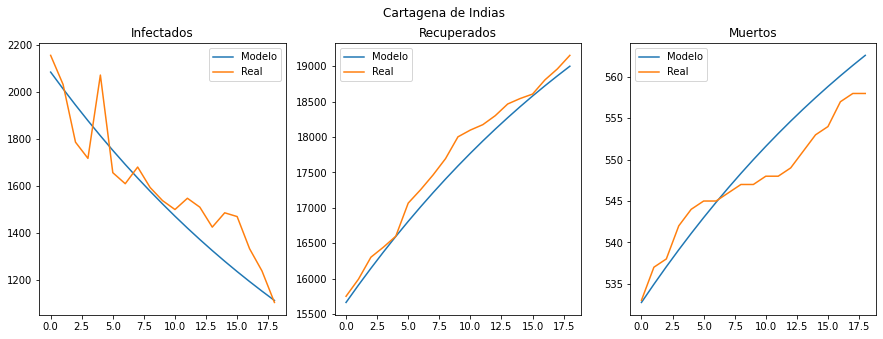

In [477]:
for city in cities:
    city_pop = df_poblacion[df_poblacion["Ciudad"] == city]["Población"].values[0]
    data = np.array([
        cities_data[city]["S"],
        cities_data[city]["I"],
        cities_data[city]["R"],
        cities_data[city]["M"],
    ])
    test_data = data[:, cutpoint:]
    days = data.shape[1] - cutpoint
    t = np.arange(days)
    preds = models[city].predict(days)
    
    ## FIGURAS
    fig, axes = plt.subplots(nrows=1, ncols=3, squeeze=False)
    fig.suptitle(city)
    axes = axes.flatten()
    # Infectados
    axes[0].plot(t , preds[1])
    axes[0].plot(t, test_data[1])
    axes[0].legend(["Modelo", "Real"])
    axes[0].set_title("Infectados")
    
    # Recuperados
    axes[1].plot(t, preds[2])
    axes[1].plot(t, test_data[2])
    axes[1].legend(["Modelo", "Real"])
    axes[1].set_title("Recuperados")
    
    # Muertos
    axes[2].plot(t, preds[3])
    axes[2].plot(t, test_data[3])
    axes[2].legend(["Modelo", "Real"])
    axes[2].set_title("Muertos")
    
    
    